In [ ]:
# =============================
# 🔹 1. Imports & Setup
# =============================
# !pip install yfinance tensorflow scikit-learn pandas matplotlib joblib --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

symbol = "BTC-USD"
interval = "1m"
period = "7d"

print(f"Téléchargement des données pour {symbol} ({interval}, {period})...")
df = yf.download(symbol, interval=interval, period=period, auto_adjust=True)
df = df.dropna()
df.tail()

Téléchargement des données pour BTC-USD (1h, 180d)...


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Datetime,,,,,
2025-10-21 09:00:00+00:00,107769.960938,107879.406250,107620.718750,107739.703125,0
2025-10-21 10:00:00+00:00,108611.679688,108738.203125,107626.843750,107790.234375,7044591616
2025-10-21 11:00:00+00:00,108604.484375,108641.937500,108235.562500,108510.148438,2428817408
2025-10-21 12:00:00+00:00,108920.343750,109450.421875,108548.398438,108615.484375,7304515584
2025-10-21 13:00:00+00:00,108713.250000,108896.007812,108391.171875,108886.953125,1831018496


In [2]:
# =============================
# 🔹 2. Préparation des données
# =============================
data = df[['Close']].astype('float32').values
train_ratio = 0.85
split_idx = int(len(data) * train_ratio)

train_vals = data[:split_idx]
test_vals  = data[split_idx:]

# Normalisation
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals)
test_scaled  = scaler.transform(test_vals)

print(f"Train : {train_scaled.shape}, Test : {test_scaled.shape}")


Train : (3663, 1), Test : (647, 1)


In [3]:
# =============================
# 🔹 3. Création des séquences (look_back)
# =============================
look_back = 72  # 3 jours si interval = 1h

def make_xy(series, L):
    X, y = [], []
    for i in range(L, len(series)):
        X.append(series[i-L:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X_train, y_train = make_xy(train_scaled, look_back)
X_test, y_test = make_xy(test_scaled, look_back)

print("X_train :", X_train.shape, "y_train :", y_train.shape)


X_train : (3591, 72, 1) y_train : (3591, 1)


In [4]:
# =============================
# 🔹 4. Construction du modèle LSTM
# =============================
model = Sequential([
    LSTM(64, input_shape=(look_back, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\Miguel\anaconda3\envs\tfcpu\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0147 - val_loss: 0.0013
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 6.3615e-04 - val_loss: 0.0013
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 5.9700e-04 - val_loss: 0.0013
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 5.7001e-04 - val_loss: 0.0012
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 5.3166e-04 - val_loss: 0.0012
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 4.9833e-04 - val_loss: 0.0010
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 4.7412e-04 - val_loss: 9.9947e-04
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 4.6139e-04 - val_loss: 9.2186e-04
Epoch 9/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 4.4583e-04 - val_loss: 8.4465e-04
Epoch 10/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 4.1028e-04 - val_loss: 9.2005e-04
Epoch 11/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 4.0868e-04 - va

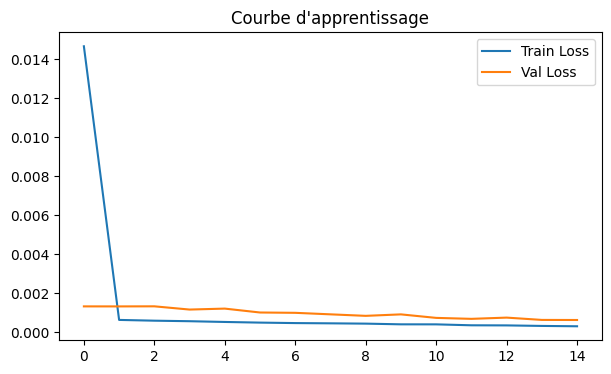

In [5]:
# =============================
# 🔹 5. Entraînement du modèle
# =============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15, batch_size=32, verbose=1
)

plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Courbe d'apprentissage")
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAE  = 543.56MAE  = 543.56
RMSE = 775.77

RMSE = 775.77


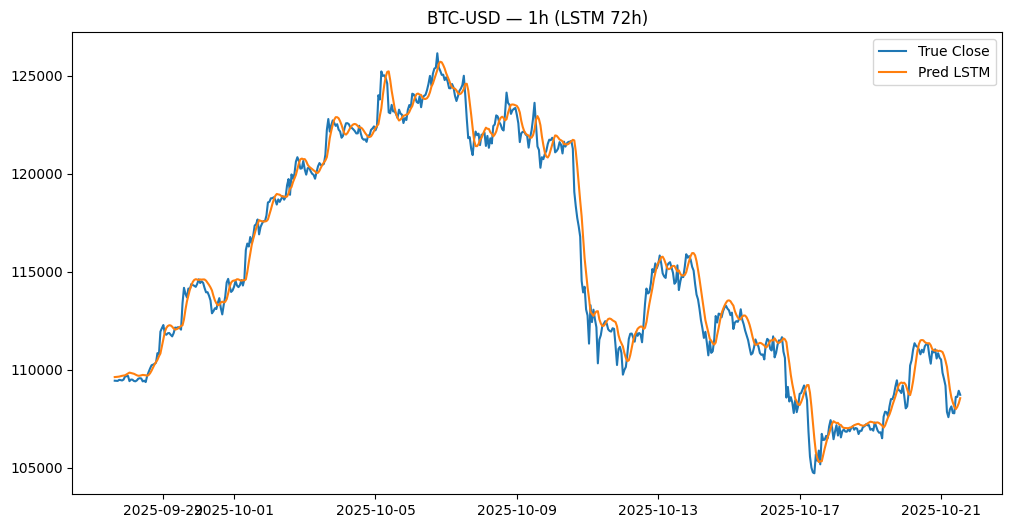

In [8]:
# =============================
# 🔹 6. Prédiction sur le test
# =============================
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
true = scaler.inverse_transform(y_test)

mae = mean_absolute_error(true, pred)
rmse = np.sqrt(mean_squared_error(true, pred))
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df.index[-len(true):], true, label="True Close")
plt.plot(df.index[-len(pred):], pred, label="Pred LSTM")
plt.title(f"{symbol} — {interval} (LSTM {look_back}h)")
plt.legend()
plt.show()


In [ ]:
# =============================
# 🔹 7. Sauvegarde du modèle et du scaler
# =============================
# model.save("model.h5")
# joblib.dump({"scaler": scaler, "look_back": look_back}, "preproc.pkl")

print("✅ Modèle et scaler sauvegardés avec succès !")
